In [1]:
cd

C:\Users\User


In [138]:
pip install scikit-learn==0.22

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\programdata\\anaconda3\\envs\\py3_7_6\\lib\\site-packages\\scikit_learn-0.24.1.dist-info\\COPYING'
Consider using the `--user` option or check the permissions.



In [129]:
pip install tslearn

Note: you may need to restart the kernel to use updated packages.


In [457]:
import pandas as pd
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import *
from sklearn.cluster import KMeans
from tslearn.clustering import *

from statsmodels import datasets
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [4]:
train=pd.read_csv('./Desktop/kaggle_semi_project/sales_train.csv')
test=pd.read_csv('./Desktop/kaggle_semi_project/test.csv')
item_cat=pd.read_csv('./Desktop/kaggle_semi_project/item_categories.csv')
items=pd.read_csv('./Desktop/kaggle_semi_project/items.csv')
shops=pd.read_csv('./Desktop/kaggle_semi_project/shops.csv')
sample_sub=pd.read_csv('./Desktop/kaggle_semi_project/sample_submission.csv')

In [5]:
train.drop_duplicates(keep = 'first',inplace = True)

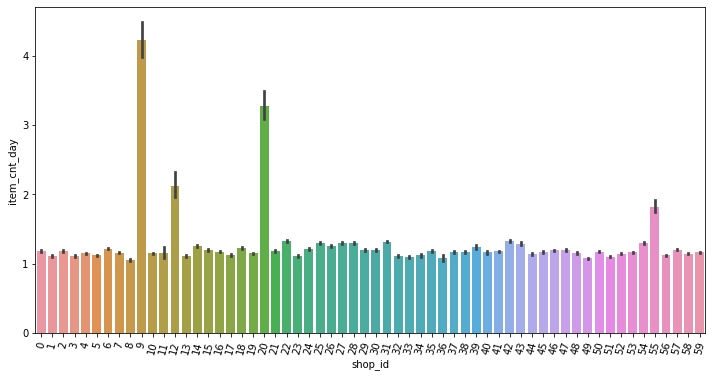

In [6]:

plt.figure(figsize=(12,6))
sns.barplot(x='shop_id',y='item_cnt_day',data=train)
plt.xticks(rotation=75)
plt.show() #9번가게,12번가게,20번가게,55번가게는 다른가게들보다 장사가 잘되는듯? 그렇다면 이가게들의 특성은 판매량과 연결될수있을듯

<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_day'>

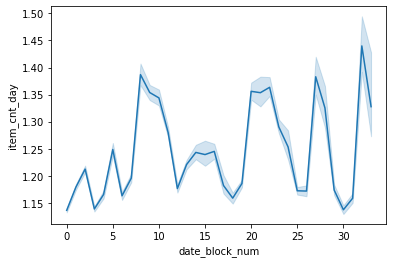

In [7]:
sns.lineplot(x='date_block_num',y='item_cnt_day',data=train)#2013년~2015년까지 월별로 판매량이 시계열성이 있는것을 알수있다.

<AxesSubplot:xlabel='item_price', ylabel='item_cnt_day'>

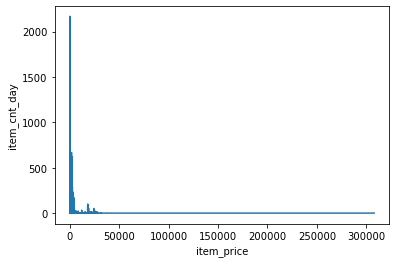

In [8]:
sns.lineplot(x='item_price',y='item_cnt_day',data=train) #잘은모르겠지만 가격이 높을수록 판매량이 적어지는듯

<AxesSubplot:xlabel='item_id', ylabel='Count'>

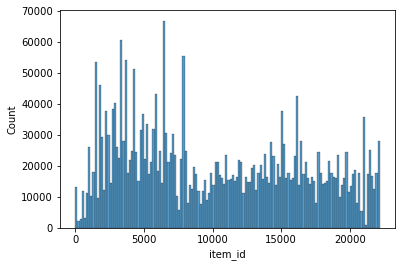

In [9]:
sns.histplot(x='item_id',data=train) #물품종목의 분포가 어떤지 확인 정규분포는 아닌듯

In [10]:
df=train.copy()

In [11]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [12]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
item_df=pd.merge(items,item_cat,how='left',on='item_category_id')

In [14]:
item_df=item_df[['item_category_name','item_name','item_category_id','item_id']]

In [15]:
item_df.head()  #카테고리별 아이템 이름의 카테고리 고유값과 아이템 고유값을 보기 편하게 하기위해

,item_category_name,item_name,item_category_id,item_id
0,Кино - DVD,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,0
1,Программы - Для дома и офиса (Цифра),!ABBYY FineReader 12 Professional Edition Full...,76,1
2,Кино - DVD,***В ЛУЧАХ СЛАВЫ (UNV) D,40,2
3,Кино - DVD,***ГОЛУБАЯ ВОЛНА (Univ) D,40,3
4,Кино - DVD,***КОРОБКА (СТЕКЛО) D,40,4


In [16]:
df['date']=pd.to_datetime(train.date, format = '%d.%m.%Y' )

In [23]:
df=df.set_index('date').sort_index()

In [20]:
df=df.reset_index()

In [24]:
df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-01,0,18,16182,1619.0,1.0
2013-01-01,0,54,12355,399.0,1.0
2013-01-01,0,54,16877,149.0,1.0
2013-01-01,0,27,15435,499.0,1.0
2013-01-01,0,54,19678,149.0,1.0


In [25]:
df['year_month'] = df.index.strftime('%Y-%m')

In [28]:
df=df.reset_index()


In [30]:
df['year']=df['date'].dt.year
df['month']= df['date'].dt.month
df['day']=df['date'].dt.day
df['weekday']= df['date'].dt.weekday

In [36]:
def is_weekend(x):
    if x == 5:
        return 1
    elif x == 6:
        return 1
    else:
        return 0

In [37]:
df['weekend'] = df['weekday'].apply(is_weekend)

In [40]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend
0,2013-01-01,0,18,16182,1619.0,1.0,2013-01,2013,1,1,1,0
1,2013-01-01,0,54,12355,399.0,1.0,2013-01,2013,1,1,1,0
2,2013-01-01,0,54,16877,149.0,1.0,2013-01,2013,1,1,1,0
3,2013-01-01,0,27,15435,499.0,1.0,2013-01,2013,1,1,1,0
4,2013-01-01,0,54,19678,149.0,1.0,2013-01,2013,1,1,1,0


In [41]:
df['sale_day'] = df['item_price'] * df['item_cnt_day']

In [42]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend,sale_day
0,2013-01-01,0,18,16182,1619.0,1.0,2013-01,2013,1,1,1,0,1619.0
1,2013-01-01,0,54,12355,399.0,1.0,2013-01,2013,1,1,1,0,399.0
2,2013-01-01,0,54,16877,149.0,1.0,2013-01,2013,1,1,1,0,149.0
3,2013-01-01,0,27,15435,499.0,1.0,2013-01,2013,1,1,1,0,499.0
4,2013-01-01,0,54,19678,149.0,1.0,2013-01,2013,1,1,1,0,149.0


In [48]:
df2 = pd.merge(df,item_df,how='left',on='item_id')

In [49]:
df2.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend,sale_day,item_category_name,item_name,item_category_id
0,2013-01-01,0,18,16182,1619.0,1.0,2013-01,2013,1,1,1,0,1619.0,Подарки - Настольные игры,Настольная игра Монополия арт. 00009H,64
1,2013-01-01,0,54,12355,399.0,1.0,2013-01,2013,1,1,1,0,399.0,Кино - DVD,КАК ПО МАСЛУ,40
2,2013-01-01,0,54,16877,149.0,1.0,2013-01,2013,1,1,1,0,149.0,Кино - DVD,ПАРАНОРМАЛЬНОЕ ЯВЛЕНИЕ (регион),40
3,2013-01-01,0,27,15435,499.0,1.0,2013-01,2013,1,1,1,0,499.0,Подарки - Мягкие игрушки,Мягкая игрушка СОЮЗМУЛЬТФИЛЬМ Бонифаций,63
4,2013-01-01,0,54,19678,149.0,1.0,2013-01,2013,1,1,1,0,149.0,Кино - DVD,ТИТАНИК (регион),40


In [106]:
cat_sum = pd.pivot_table(df2, index = 'date_block_num', 
                              columns = 'item_category_id',
                              values = 'item_cnt_day', 
                              aggfunc = np.sum,
                              fill_value = 0)

In [107]:
cat_sum

item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,1,1,1390,440,251,623,870,0,0,149,...,0,2980,0,481,0,145,0,177,1374,894
1,1,1,1190,302,220,358,668,0,0,159,...,0,2670,0,519,0,128,0,111,1192,574
2,0,0,1025,293,226,354,646,0,0,211,...,0,2523,0,431,0,275,0,106,1125,675
3,1,0,646,202,160,275,465,0,0,138,...,0,1998,0,394,0,94,0,115,1021,523
4,0,0,596,146,175,281,441,0,0,95,...,0,1568,95,272,37,83,0,113,1139,527
5,0,0,667,150,176,329,502,0,0,124,...,0,1442,98,256,82,64,0,75,1114,761
6,0,0,618,233,179,355,622,0,0,83,...,0,1519,100,291,55,64,0,98,889,676
7,0,0,674,300,140,299,637,0,0,124,...,0,1639,105,233,36,67,0,48,657,444
8,0,0,792,383,86,289,729,0,0,141,...,0,1846,121,131,149,52,0,32,506,278


In [108]:
cat_sum.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
           dtype='int64', name='item_category_id')

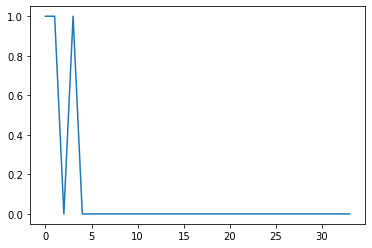

In [111]:
plt.plot(cat_sum[0])

In [135]:
cd

C:\Users\User


In [136]:
cat_sum.to_csv("./Desktop/csv/cat_sum.csv")

<AxesSubplot:xlabel='date_block_num'>

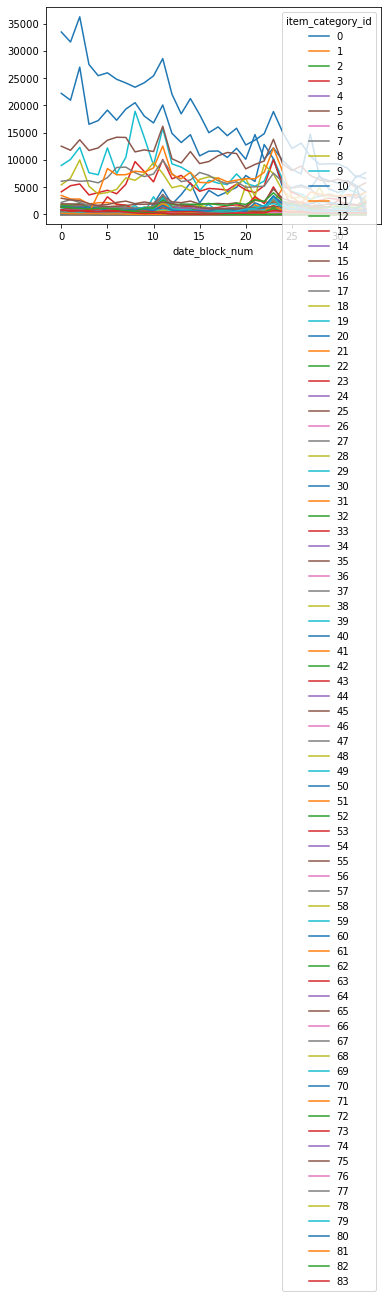

In [132]:

cat_sum.plot()

In [252]:
cat_sum.head()

item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
date_block_num,,,,,,,,,,,,,,,,,,,,,
0,1,1,1390,440,251,623,870,0,0,149,...,0,2980,0,481,0,145,0,177,1374,894
1,1,1,1190,302,220,358,668,0,0,159,...,0,2670,0,519,0,128,0,111,1192,574
2,0,0,1025,293,226,354,646,0,0,211,...,0,2523,0,431,0,275,0,106,1125,675
3,1,0,646,202,160,275,465,0,0,138,...,0,1998,0,394,0,94,0,115,1021,523
4,0,0,596,146,175,281,441,0,0,95,...,0,1568,95,272,37,83,0,113,1139,527


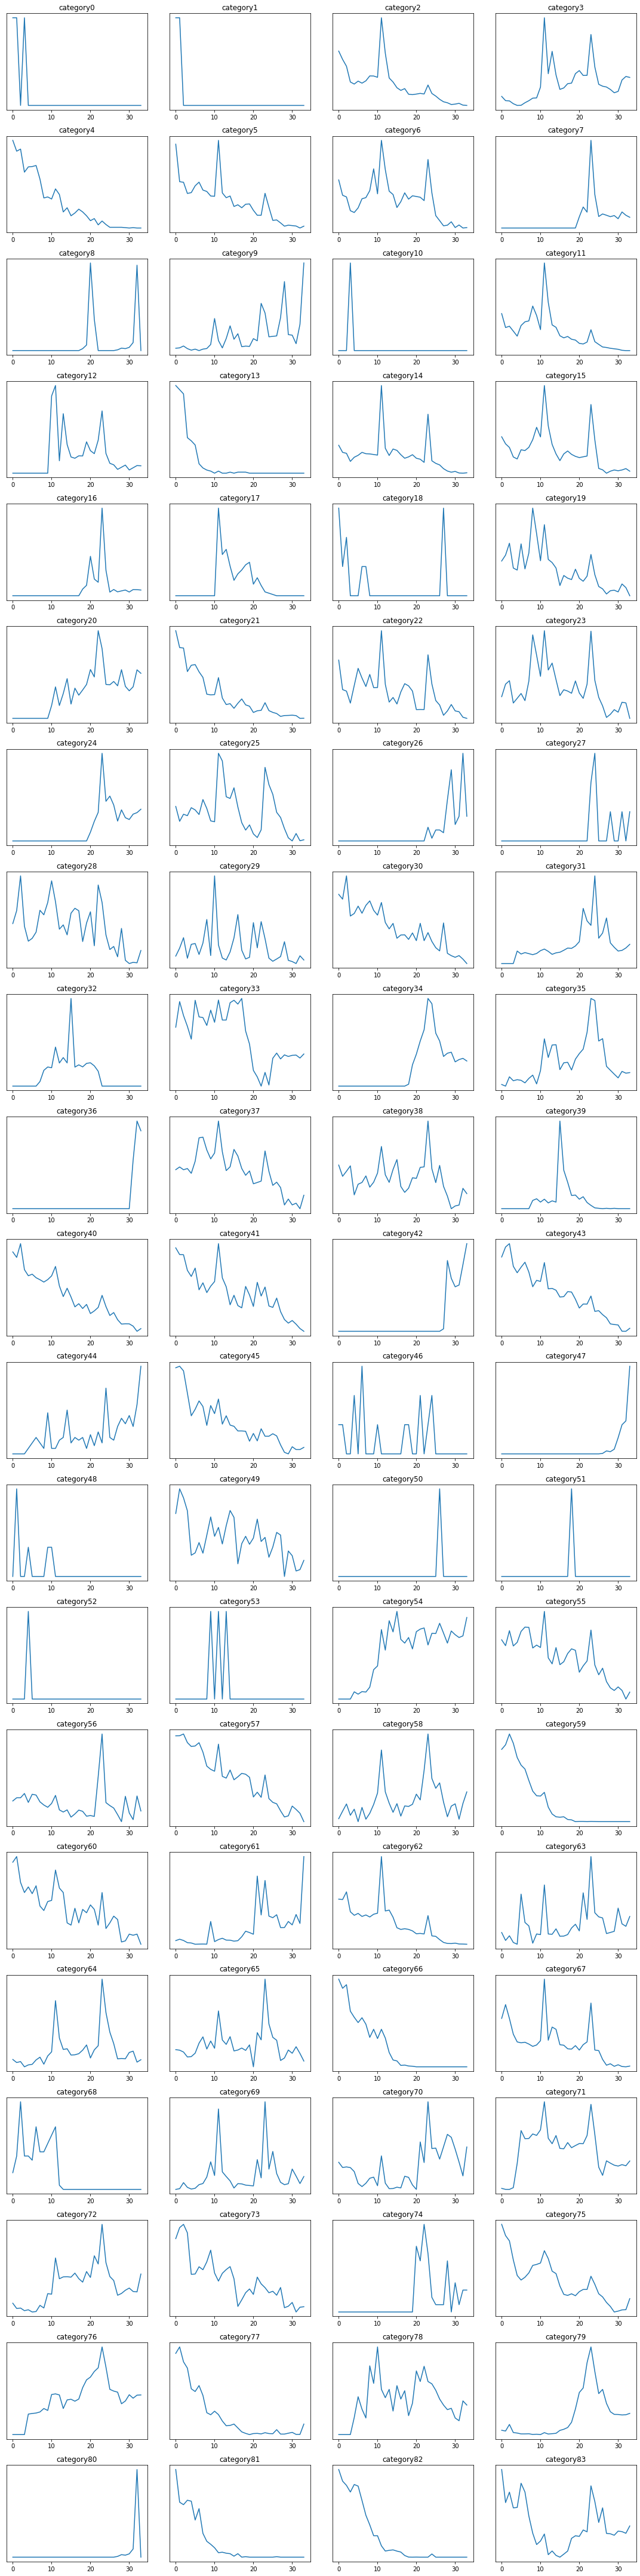

In [325]:
plt.figure(figsize=(15,60))

for i in range(1,85):  
    plt.subplot(21,4, i)
    plt.plot(cat_sum[i-1])
    plt.title(f'category{i-1}')
    plt.tight_layout()
    plt.yticks([])
    

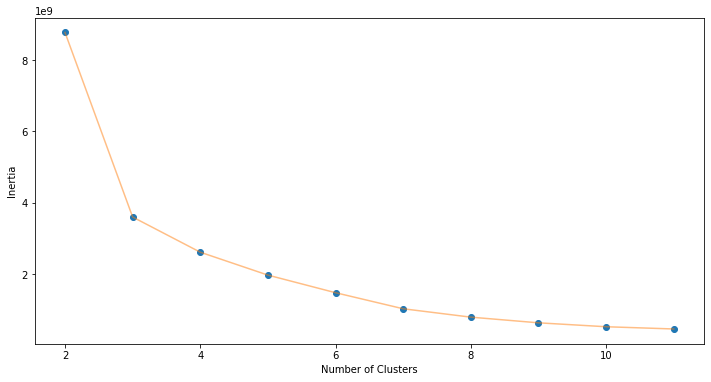

In [326]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cat_sum_t)

In [327]:
kmeans = KMeans(n_clusters=3, random_state = 2)
km_cluster = kmeans.fit_predict(cat_sum_t)

In [328]:
df_clust = cat_sum_t.copy()
df_clust['km_cluster'] = km_cluster

In [331]:
df_clust

date_block_num,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,km_cluster
item_category_id,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1390,1190,1025,646,596,667,618,674,792,790,...,307,229,170,146,104,114,132,89,82,0
3,440,302,293,202,146,150,233,300,383,391,...,834,773,746,667,559,603,975,1090,1059,0
4,251,220,226,160,175,176,179,140,86,89,...,2,2,2,2,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,145,128,275,94,83,64,64,67,52,57,...,962,1056,744,558,499,497,486,491,521,0
80,0,0,0,0,0,0,0,0,0,0,...,0,0,45,147,117,195,483,5149,0,0
81,177,111,106,115,113,75,98,48,32,26,...,0,1,0,0,0,0,0,0,0,0


In [351]:
len(np.unique(df_clust.km_cluster)) 

3

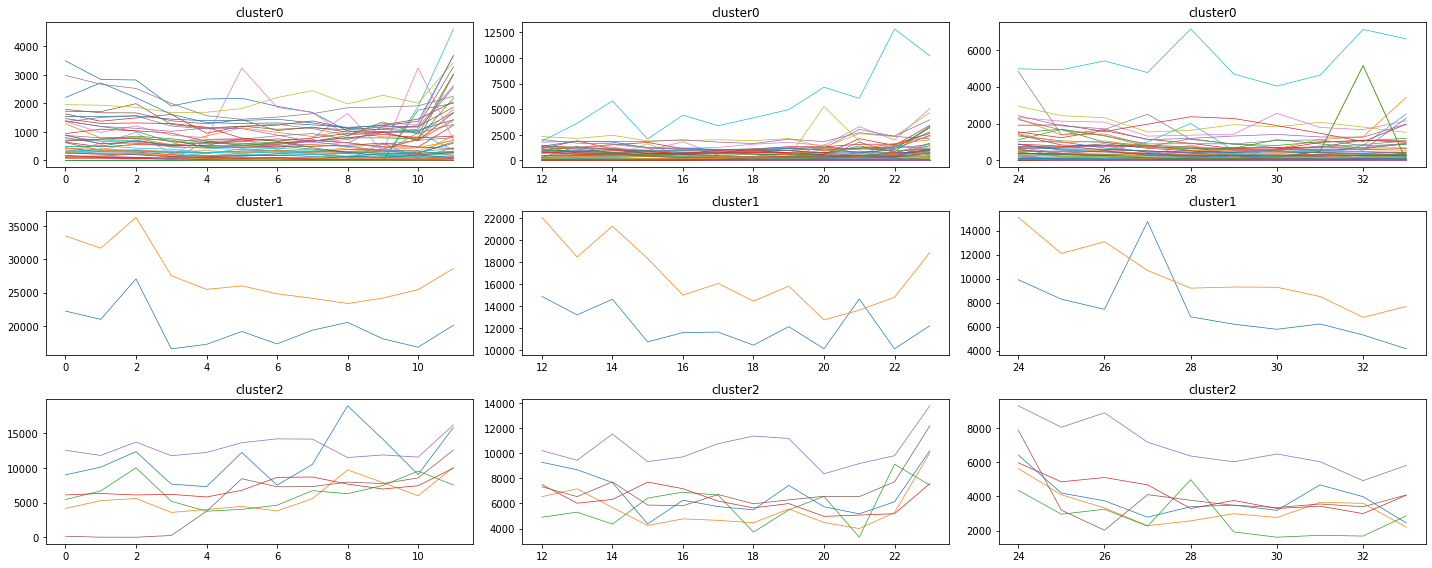

In [355]:
n_c = len(np.unique(df_clust.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,3,3*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,0:12], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.tight_layout()
    plt.subplot(n_c,3,3*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,12:24], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.tight_layout()
    plt.subplot(n_c,3,3*c+3)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,24:-1], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        

In [197]:

df_clust.to_csv("./Desktop/csv/df_clust.csv")

date_block_num,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,km_cluster
item_category_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1390,1190,1025,646,596,667,618,674,792,790,...,307,229,170,146,104,114,132,89,82,0
3,440,302,293,202,146,150,233,300,383,391,...,834,773,746,667,559,603,975,1090,1059,0
4,251,220,226,160,175,176,179,140,86,89,...,2,2,2,2,1,0,1,0,0,0
5,623,358,354,275,281,329,355,299,289,257,...,85,88,67,44,51,48,45,31,44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,145,128,275,94,83,64,64,67,52,57,...,962,1056,744,558,499,497,486,491,521,0
80,0,0,0,0,0,0,0,0,0,0,...,0,0,45,147,117,195,483,5149,0,0
81,177,111,106,115,113,75,98,48,32,26,...,0,1,0,0,0,0,0,0,0,0


In [199]:
df2.set_index('item_category_id')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend,sale_day,item_category_name,item_name
item_category_id,,,,,,,,,,,,,,,
64,2013-01-01,0,18,16182,1619.0,1.0,2013-01,2013,1,1,1,0,1619.0,Подарки - Настольные игры,Настольная игра Монополия арт. 00009H
40,2013-01-01,0,54,12355,399.0,1.0,2013-01,2013,1,1,1,0,399.0,Кино - DVD,КАК ПО МАСЛУ
40,2013-01-01,0,54,16877,149.0,1.0,2013-01,2013,1,1,1,0,149.0,Кино - DVD,ПАРАНОРМАЛЬНОЕ ЯВЛЕНИЕ (регион)
63,2013-01-01,0,27,15435,499.0,1.0,2013-01,2013,1,1,1,0,499.0,Подарки - Мягкие игрушки,Мягкая игрушка СОЮЗМУЛЬТФИЛЬМ Бонифаций
40,2013-01-01,0,54,19678,149.0,1.0,2013-01,2013,1,1,1,0,149.0,Кино - DVD,ТИТАНИК (регион)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,2015-10-31,33,50,8918,28.0,1.0,2015-10,2015,10,31,5,1,28.0,Кино - DVD,БЛОНДИНКА В ЭФИРЕ
58,2015-10-31,33,6,8116,1699.0,1.0,2015-10,2015,10,31,5,1,1699.0,Музыка - Винил,АГАТА КРИСТИ Позорная звезда LP
20,2015-10-31,33,37,2423,499.0,3.0,2015-10,2015,10,31,5,1,1497.0,Игры - PS4,"Crew [PS4, русская версия]"


In [201]:
df_clust.drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33],inplace=True)

In [212]:
df_clust=df_clust.reset_index()

In [226]:
df_clust[['item_category_id','km_cluster']]

date_block_num,item_category_id,km_cluster
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
79,79,0
80,80,0
81,81,0
82,82,0


In [227]:
df_clust.

date_block_num,km_cluster
item_category_id,
0,0
1,0
2,0
3,0
4,0
...,...
79,0
80,0
81,0


In [228]:
df_clust=pd.read_csv('./Desktop/csv/df_clust.csv')

In [229]:
df_clust=df_clust[['item_category_id','km_cluster']]

In [231]:
df_clust=df_clust.set_index('item_category_id')

In [232]:
df_clust

,km_cluster
item_category_id,
0,0
1,0
2,0
3,0
4,0
...,...
79,0
80,0
81,0


In [234]:
df3=df2.set_index('item_category_id')

In [237]:
df3=df3.join(df_clust,how='left')

In [248]:
df3=df3.reset_index()

In [249]:
df3=df3.set_index('date').sort_index()

In [256]:
df3=df3.reset_index()

In [255]:
df3

,item_category_id,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend,sale_day,item_category_name,item_name,km_cluster
date,,,,,,,,,,,,,,,,
2013-01-01,21,0,54,2956,598.75,2.0,2013-01,2013,1,1,1,0,1197.5,Игры - PSP,Disney/Pixar. История игрушек. Большой побег (...,0
2013-01-01,37,0,28,10110,499.00,1.0,2013-01,2013,1,1,1,0,499.0,Кино - Blu-Ray,ВСПОМНИТЬ ВСЕ (BD),2
2013-01-01,37,0,28,21846,999.00,1.0,2013-01,2013,1,1,1,0,999.0,Кино - Blu-Ray,ШЕРЛОК ХОЛМС WB (BD),2
2013-01-01,37,0,27,10039,299.00,1.0,2013-01,2013,1,1,1,0,299.0,Кино - Blu-Ray,ВОССТАНИЕ ПЛАНЕТЫ ОБЕЗЬЯН (BD),2
2013-01-01,37,0,54,21856,149.00,1.0,2013-01,2013,1,1,1,0,149.0,Кино - Blu-Ray,ШЕРЛОК. СЕЗОН 1 (BD),2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-31,71,33,25,20949,5.00,24.0,2015-10,2015,10,31,5,1,120.0,"Подарки - Сумки, Альбомы, Коврики д/мыши",Фирменный пакет майка 1С Интерес белый (34*42)...,2
2015-10-31,71,33,56,20949,5.00,4.0,2015-10,2015,10,31,5,1,20.0,"Подарки - Сумки, Альбомы, Коврики д/мыши",Фирменный пакет майка 1С Интерес белый (34*42)...,2
2015-10-31,71,33,14,20949,5.00,4.0,2015-10,2015,10,31,5,1,20.0,"Подарки - Сумки, Альбомы, Коврики д/мыши",Фирменный пакет майка 1С Интерес белый (34*42)...,2


In [269]:
df3.to_csv('./Desktop/csv/df3.csv')

In [271]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935843 entries, 0 to 2935842
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   item_category_id    int64         
 2   date_block_num      int64         
 3   shop_id             int64         
 4   item_id             int64         
 5   item_price          float64       
 6   item_cnt_day        float64       
 7   year_month          object        
 8   year                int64         
 9   month               int64         
 10  day                 int64         
 11  weekday             int64         
 12  weekend             int64         
 13  sale_day            float64       
 14  item_category_name  object        
 15  item_name           object        
 16  km_cluster          int64         
dtypes: datetime64[ns](1), float64(3), int64(10), object(3)
memory usage: 380.8+ MB


In [272]:
df3.head()

,date,item_category_id,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend,sale_day,item_category_name,item_name,km_cluster
0,2013-01-01,21,0,54,2956,598.75,2.0,2013-01,2013,1,1,1,0,1197.5,Игры - PSP,Disney/Pixar. История игрушек. Большой побег (...,0
1,2013-01-01,37,0,28,10110,499.00,1.0,2013-01,2013,1,1,1,0,499.0,Кино - Blu-Ray,ВСПОМНИТЬ ВСЕ (BD),2
2,2013-01-01,37,0,28,21846,999.00,1.0,2013-01,2013,1,1,1,0,999.0,Кино - Blu-Ray,ШЕРЛОК ХОЛМС WB (BD),2
3,2013-01-01,37,0,27,10039,299.00,1.0,2013-01,2013,1,1,1,0,299.0,Кино - Blu-Ray,ВОССТАНИЕ ПЛАНЕТЫ ОБЕЗЬЯН (BD),2
4,2013-01-01,37,0,54,21856,149.00,1.0,2013-01,2013,1,1,1,0,149.0,Кино - Blu-Ray,ШЕРЛОК. СЕЗОН 1 (BD),2


In [273]:
df3.

Index(['date', 'item_category_id', 'date_block_num', 'shop_id', 'item_id',
       'item_price', 'item_cnt_day', 'year_month', 'year', 'month', 'day',
       'weekday', 'weekend', 'sale_day', 'item_category_name', 'item_name',
       'km_cluster'],
      dtype='object')

In [278]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [279]:
df3

,date,item_category_id,date_block_num,shop_id,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend,sale_day,item_category_name,item_name,km_cluster
0,2013-01-01,21,0,54,2956,598.75,2.0,2013-01,2013,1,1,1,0,1197.5,Игры - PSP,Disney/Pixar. История игрушек. Большой побег (...,0
1,2013-01-01,37,0,28,10110,499.00,1.0,2013-01,2013,1,1,1,0,499.0,Кино - Blu-Ray,ВСПОМНИТЬ ВСЕ (BD),2
2,2013-01-01,37,0,28,21846,999.00,1.0,2013-01,2013,1,1,1,0,999.0,Кино - Blu-Ray,ШЕРЛОК ХОЛМС WB (BD),2
3,2013-01-01,37,0,27,10039,299.00,1.0,2013-01,2013,1,1,1,0,299.0,Кино - Blu-Ray,ВОССТАНИЕ ПЛАНЕТЫ ОБЕЗЬЯН (BD),2
4,2013-01-01,37,0,54,21856,149.00,1.0,2013-01,2013,1,1,1,0,149.0,Кино - Blu-Ray,ШЕРЛОК. СЕЗОН 1 (BD),2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935838,2015-10-31,71,33,25,20949,5.00,24.0,2015-10,2015,10,31,5,1,120.0,"Подарки - Сумки, Альбомы, Коврики д/мыши",Фирменный пакет майка 1С Интерес белый (34*42)...,2
2935839,2015-10-31,71,33,56,20949,5.00,4.0,2015-10,2015,10,31,5,1,20.0,"Подарки - Сумки, Альбомы, Коврики д/мыши",Фирменный пакет майка 1С Интерес белый (34*42)...,2
2935840,2015-10-31,71,33,14,20949,5.00,4.0,2015-10,2015,10,31,5,1,20.0,"Подарки - Сумки, Альбомы, Коврики д/мыши",Фирменный пакет майка 1С Интерес белый (34*42)...,2
2935841,2015-10-31,71,33,26,20949,5.00,3.0,2015-10,2015,10,31,5,1,15.0,"Подарки - Сумки, Альбомы, Коврики д/мыши",Фирменный пакет майка 1С Интерес белый (34*42)...,2


In [280]:
shop_clust = pd.read_csv('./Desktop/csv/sample.csv')

In [283]:
shop_clust

,shop_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,...,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,shop_cluster
0,0,3626,3957,403,473,465,403,267,550,494,...,0,0,0,0,0,0,0,0,0,3
1,1,1955,2298,310,99,242,216,87,267,262,...,0,0,0,0,0,0,0,0,0,3
2,2,748,722,821,678,659,872,805,847,886,...,861,866,733,732,936,663,736,264,207,3
3,3,670,924,894,727,783,784,800,930,1009,...,731,694,583,603,692,673,596,247,196,3
4,4,1685,2069,1806,639,1397,1518,1579,1740,1499,...,950,841,765,902,921,734,750,299,252,0
5,5,446,1171,1206,967,1007,1204,1374,1418,1371,...,1066,994,880,1013,1269,1036,950,404,315,0
6,6,3403,4042,4370,3130,3459,3902,3659,3736,4114,...,2032,1812,1504,1579,1575,1594,1733,550,500,0
7,7,2091,2677,2510,1768,1859,2177,2289,2399,2505,...,1364,1366,1175,1323,1432,1171,1152,462,419,0
8,8,747,963,692,139,139,118,119,166,201,...,0,0,0,0,0,0,0,0,0,3
9,9,0,0,543,1573,2131,2279,0,0,0,...,966,0,0,0,0,0,-1,0,0,3


In [284]:
shop_clust=shop_clust[['shop_id','shop_cluster']]

In [291]:
shop_clust=shop_clust.set_index('shop_id')

In [294]:
shop_clust.head()

,shop_cluster
shop_id,
0,3
1,3
2,3
3,3
4,0


In [307]:
df4=df3.set_index('shop_id')

In [308]:
df4=df4.join(shop_clust,how='left')

In [309]:
df4=df4.reset_index()

In [311]:
df4=df4.set_index('date').sort_index()

In [312]:
df4.head()

,shop_id,item_category_id,date_block_num,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend,sale_day,item_category_name,item_name,km_cluster,shop_cluster
date,,,,,,,,,,,,,,,,,
2013-01-01,2,40,0,8665,299.0,1.0,2013-01,2013,1,1,1,0,299.0,Кино - DVD,БАРБОСКИНЫ ВЫПУСК 5: УЧЕНИК ЧАРОДЕЯ,1,3
2013-01-01,54,2,0,5641,2390.0,1.0,2013-01,2013,1,1,1,0,2390.0,Аксессуары - PS3,PS3: Контроллер игровой беспроводной синий (Du...,0,2
2013-01-01,54,2,0,5635,2390.0,1.0,2013-01,2013,1,1,1,0,2390.0,Аксессуары - PS3,PS3: Контроллер игровой беспроводной серебрист...,0,2
2013-01-01,54,2,0,5574,699.0,1.0,2013-01,2013,1,1,1,0,699.0,Аксессуары - PS3,PS Move Navigation Controller (Дополнительный ...,0,2
2013-01-01,54,2,0,5572,1590.0,2.0,2013-01,2013,1,1,1,0,3180.0,Аксессуары - PS3,PS Move Motion Controller (Контроллер движений...,0,2


In [319]:
df4.to_csv('./Desktop/csv/df4.csv')

In [316]:
sample_sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [317]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [321]:
df_month = pd.pivot_table(df4, index = ['shop_id','item_id'], 
                              columns = 'date_block_num',
                              values = 'item_cnt_day', 
                              fill_value = 0,
                              aggfunc = np.sum)

In [322]:
df_month

date_block_num   0   1   2   3   4   5   6   7   8   9   ...  24  25  26  27  \
shop_id item_id                                          ...                   
0       30        0  31   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        31        0  11   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        32        6  10   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        33        3   3   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        35        1  14   0   0   0   0   0   0   0   0  ...   0   0   0   0   
...              ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
59      22154     1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
        22155     0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   
        22162     0   0   0   0   0   0   0   0   0   0  ...   0   9   4   1   
        22164     0   0   0   0   0   0   0   0   0   0  ...   0   2   1   2   
        22167     0   0   0   0   0   0   0   0   0   1  ...   0   0   0   0   

date_block_num   28  29  30  31  32  33  
shop_id item_id                          
0       30        0   0   0   0   0   0  
        31        0   0   0   0   0   0  
        32        0   0   0   0   0   0  
        33        0   0   0   0   0   0  
        35        0   0   0   0   0   0  
...              ..  ..  ..  ..  ..  ..  
59      22154     0   0   0   0   0   0  
        22155     0   0   0   0   0   0  
        22162     1   0   0   1   0   0  
        22164     0   0   1   0   0   0  
        22167     0   0   0   0   0   0  

[424124 rows x 34 columns]

In [390]:
df4['item_id'].unique().sum()

242029335

In [359]:
df5=df4.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].agg([('cnt_month','sum')]).reset_index()

In [362]:
df5

,shop_id,item_id,date_block_num,cnt_month
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0
...,...,...,...,...
1609119,59,22164,27,2.0
1609120,59,22164,30,1.0
1609121,59,22167,9,1.0
1609122,59,22167,11,2.0


In [364]:
test.set_index(['shop_id', 'item_id'])

ID
shop_id item_id        
5       5037          0
        5320          1
        5233          2
        5232          3
        5268          4
...                 ...
45      18454    214195
        16188    214196
        15757    214197
        19648    214198
        969      214199

[214200 rows x 1 columns]

In [377]:
df6=pd.merge(df4,df5,how='left',on=['shop_id','item_id','date_block_num'])

In [376]:
df4=df4.reset_index()

In [382]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935843 entries, 0 to 2935842
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   shop_id             int64         
 2   item_category_id    int64         
 3   date_block_num      int64         
 4   item_id             int64         
 5   item_price          float64       
 6   item_cnt_day        float64       
 7   year_month          object        
 8   year                int64         
 9   month               int64         
 10  day                 int64         
 11  weekday             int64         
 12  weekend             int64         
 13  sale_day            float64       
 14  item_category_name  object        
 15  item_name           object        
 16  km_cluster          int64         
 17  shop_cluster        int64         
dtypes: datetime64[ns](1), float64(3), int64(11), object(3)
memory usage: 403.2+ MB


In [385]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   shop_id         1609124 non-null  int64  
 1   item_id         1609124 non-null  int64  
 2   date_block_num  1609124 non-null  int64  
 3   cnt_month       1609124 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 49.1 MB


In [392]:
df6.head()


,date,shop_id,item_category_id,date_block_num,item_id,item_price,item_cnt_day,year_month,year,month,day,weekday,weekend,sale_day,item_category_name,item_name,km_cluster,shop_cluster,cnt_month
0,2013-01-01,2,40,0,8665,299.0,1.0,2013-01,2013,1,1,1,0,299.0,Кино - DVD,БАРБОСКИНЫ ВЫПУСК 5: УЧЕНИК ЧАРОДЕЯ,1,3,1.0
1,2013-01-01,54,2,0,5641,2390.0,1.0,2013-01,2013,1,1,1,0,2390.0,Аксессуары - PS3,PS3: Контроллер игровой беспроводной синий (Du...,0,2,7.0
2,2013-01-01,54,2,0,5635,2390.0,1.0,2013-01,2013,1,1,1,0,2390.0,Аксессуары - PS3,PS3: Контроллер игровой беспроводной серебрист...,0,2,2.0
3,2013-01-01,54,2,0,5574,699.0,1.0,2013-01,2013,1,1,1,0,699.0,Аксессуары - PS3,PS Move Navigation Controller (Дополнительный ...,0,2,3.0
4,2013-01-01,54,2,0,5572,1590.0,2.0,2013-01,2013,1,1,1,0,3180.0,Аксессуары - PS3,PS Move Motion Controller (Контроллер движений...,0,2,14.0


In [391]:
df6.to_csv('./Desktop/csv/df6.csv')

<AxesSubplot:>

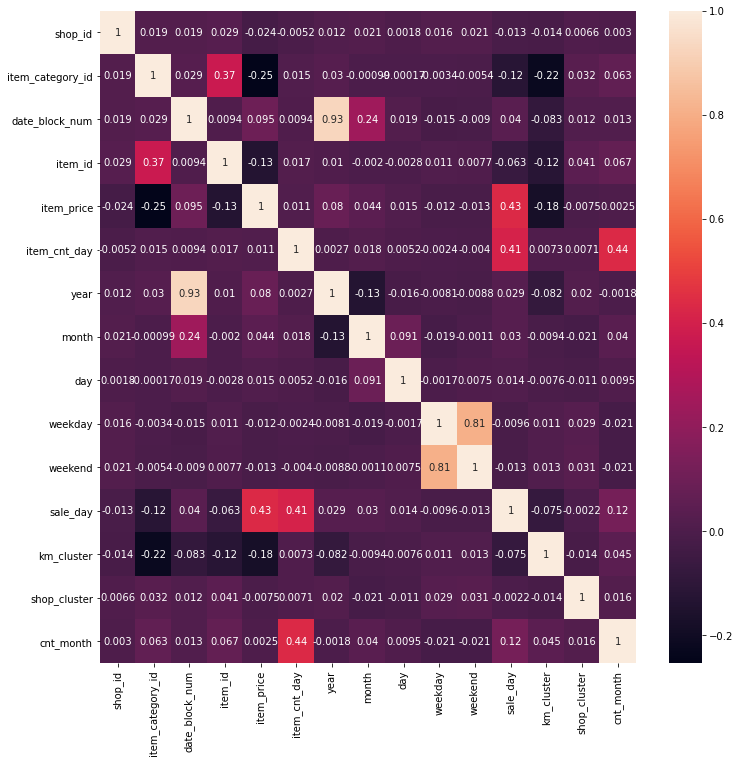

In [434]:
plt.figure(figsize=(12,12))
sns.heatmap(df6.corr(),annot=True)

In [437]:
df6.columns

Index(['date', 'shop_id', 'item_category_id', 'date_block_num', 'item_id',
       'item_price', 'item_cnt_day', 'year_month', 'year', 'month', 'day',
       'weekday', 'weekend', 'sale_day', 'item_category_name', 'item_name',
       'km_cluster', 'shop_cluster', 'cnt_month'],
      dtype='object')

In [439]:
df6_num
df6_num= df[['item_price','item_cnt_day','sale_day']]

,item_price,item_cnt_day,sale_day
0,1619.0,1.0,1619.0
1,399.0,1.0,399.0
2,149.0,1.0,149.0
3,499.0,1.0,499.0
4,149.0,1.0,149.0
...,...,...,...
2935838,28.0,1.0,28.0
2935839,1699.0,1.0,1699.0
2935840,499.0,3.0,1497.0
2935841,799.0,1.0,799.0


In [441]:
df6.columns

Index(['date', 'shop_id', 'item_category_id', 'date_block_num', 'item_id',
       'item_price', 'item_cnt_day', 'year_month', 'year', 'month', 'day',
       'weekday', 'weekend', 'sale_day', 'item_category_name', 'item_name',
       'km_cluster', 'shop_cluster', 'cnt_month'],
      dtype='object')

In [450]:
df6_cat 


,shop_id,item_category_id,date_block_num,item_id,weekend,km_cluster,shop_cluster,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2,40,0,8665,0,1,3,0,1,0,0,0,0,0
1,54,2,0,5641,0,0,2,0,1,0,0,0,0,0
2,54,2,0,5635,0,0,2,0,1,0,0,0,0,0
3,54,2,0,5574,0,0,2,0,1,0,0,0,0,0
4,54,2,0,5572,0,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935838,46,47,33,13281,1,0,0,0,0,0,0,0,1,0
2935839,46,47,33,14956,1,0,0,0,0,0,0,0,1,0
2935840,46,35,33,5821,1,0,0,0,0,0,0,0,1,0
2935841,46,37,33,16985,1,2,0,0,0,0,0,0,1,0


In [445]:

df6_cat= df6[['shop_id','item_category_id','date_block_num','item_id','weekday','weekend','km_cluster','shop_cluster']]

In [451]:
df6_num

,item_price,item_cnt_day,sale_day
0,1619.0,1.0,1619.0
1,399.0,1.0,399.0
2,149.0,1.0,149.0
3,499.0,1.0,499.0
4,149.0,1.0,149.0
...,...,...,...
2935838,28.0,1.0,28.0
2935839,1699.0,1.0,1699.0
2935840,499.0,3.0,1497.0
2935841,799.0,1.0,799.0


In [455]:
y

0           1.0
1           7.0
2           2.0
3           3.0
4          14.0
           ... 
2935838     7.0
2935839     5.0
2935840     9.0
2935841     1.0
2935842    19.0
Name: cnt_month, Length: 2935843, dtype: float64

In [452]:
df6_cat

,shop_id,item_category_id,date_block_num,item_id,weekend,km_cluster,shop_cluster,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2,40,0,8665,0,1,3,0,1,0,0,0,0,0
1,54,2,0,5641,0,0,2,0,1,0,0,0,0,0
2,54,2,0,5635,0,0,2,0,1,0,0,0,0,0
3,54,2,0,5574,0,0,2,0,1,0,0,0,0,0
4,54,2,0,5572,0,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935838,46,47,33,13281,1,0,0,0,0,0,0,0,1,0
2935839,46,47,33,14956,1,0,0,0,0,0,0,0,1,0
2935840,46,35,33,5821,1,0,0,0,0,0,0,0,1,0
2935841,46,37,33,16985,1,2,0,0,0,0,0,0,1,0


In [454]:
y=df6['cnt_month']

In [458]:
scaler = StandardScaler()
scaler.fit(df6_num)
X_scaled = scaler.transform(df6_num)
X_scaled = pd.DataFrame(X_scaled)

In [460]:
X_scaled.columns = df6_num.columns

In [462]:
X = pd.concat([X_scaled,df6_cat],axis=1)

In [463]:
X.to_csv('./Desktop/csv/X.csv')

,item_price,item_cnt_day,sale_day,shop_id,item_category_id,date_block_num,item_id,weekend,km_cluster,shop_cluster,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0.420942,-0.092652,0.081157,2,40,0,8665,0,1,3,0,1,0,0,0,0,0
1,-0.284341,-0.092652,-0.133495,54,2,0,5641,0,0,2,0,1,0,0,0,0,0
2,-0.428866,-0.092652,-0.177481,54,2,0,5635,0,0,2,0,1,0,0,0,0,0
3,-0.226531,-0.092652,-0.115900,54,2,0,5574,0,0,2,0,1,0,0,0,0,0
4,-0.428866,-0.092652,-0.177481,54,2,0,5572,0,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935838,-0.498817,-0.092652,-0.198770,46,47,33,13281,1,0,0,0,0,0,0,0,1,0
2935839,0.467190,-0.092652,0.095233,46,47,33,14956,1,0,0,0,0,0,0,0,1,0
2935840,-0.226531,0.671046,0.059692,46,35,33,5821,1,0,0,0,0,0,0,0,1,0
2935841,-0.053101,-0.092652,-0.063117,46,37,33,16985,1,2,0,0,0,0,0,0,1,0


In [468]:
X.to_csv('./Desktop/csv/X.csv')

In [464]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state =11)

In [470]:
X_scaled.head()

,item_price,item_cnt_day,sale_day
0,0.420942,-0.092652,0.081157
1,-0.284341,-0.092652,-0.133495
2,-0.428866,-0.092652,-0.177481
3,-0.226531,-0.092652,-0.115900
4,-0.428866,-0.092652,-0.177481


In [466]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [473]:
pip install lightgbm

In [474]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(random_state=11)
# 모델 학습
lgbm.fit(X_train, y_train)
# 예측값 생성
y_test = lgbm.predict(X_test)

array([4.22083846, 2.69446193, 6.51457007, ..., 3.93664778, 3.05878142,
       3.38015763])

In [478]:
from sklearn.model_selection import GridSearchCV

lf = lgb.LGBMRegressor(random_state=1217)

# 탐색할 하이퍼파라미터 값 지정
params = {'n_estimators' : [200, 300, 500],
          'max_features': [5, 6, 8],
          'min_samples_leaf' : [1, 3, 5]}

# GridSearchCV를 이용해 최적의 하이퍼파라미터 탐색
grid_cv = GridSearchCV(lf, param_grid = params, cv = 3, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터 값과 성능 출력
print('최적 하이퍼파라미터: ', grid_cv.best_params_)
print('최적 하이퍼파라미터의 성능(RMSE): {:.4f}'.format(
    np.sqrt(grid_cv.best_score_)))

C:\ProgramData\Anaconda3\envs\py3_7_6\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan 0.84747528
 0.82656213 0.83637345 0.84747528 0.82656213 0.83637345 0.84747528
 0.82656213 0.83637345 0.84747528 0.82656213 0.83637345 0.84747528
 0.82656213 0.83637345 0.84747528 0.82656213 0.83637345 0.84747528
 0.82656213 0.83637345 0.84747528]
  category=UserWarning


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
최적 하이퍼파라미터:  {'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 500}
최적 하이퍼파라미터의 성능(RMSE): 0.9206


In [479]:
model1 = lgb.LGBMRegressor(random_state=11, num_iterations = 1000, learning_rate = 0.05,
                           boosting = 'dart', Metric = 'regression_l2', n_jobs=-1)
# 모델 학습
model1.fit(X_train, y_train)
# 예측값 생성
pred1 = model1.predict(X_train)
# 성능 확인
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, pred1))

C:\ProgramData\Anaconda3\envs\py3_7_6\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


13.22300952943722

#뭔짓했는지 모르겠네


In [2]:
df6.info()


NameError: name 'df6' is not defined